In [65]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [39]:
datasets=["datasets/cnn_reduced+pylidc_features_nl.csv", "datasets/cnn_reduced_50+pylidc_features_nl.csv", "datasets/pylidc_features_nl.csv"]
df=[pd.read_csv(dataset) for dataset in datasets]

In [54]:
df1=df[2]
df1.head(5)


,Unnamed: 0,PatientID,Calcification,Lobulation,Spiculation,Internal Texture,Diameter (mm),Surface Area (mm^2),Volume (mm^3),Pixeis_in_lesion,Circularity,Median_HU_in_lesion,STD_HU_in_lesion,VAR_HU_in_lession,Mean_HU_in_lesion,Label
0,0,LIDC-IDRI-0001,6,3,4,5,32.755812,2491.466573,6989.673615,5428,0.121212,24.0,224.079908,50211.805256,-77.425571,5
1,1,LIDC-IDRI-0002,6,1,1,2,30.781671,2807.198994,7244.667508,14252,0.243756,-725.0,133.215507,17746.371374,-703.924993,5
2,2,LIDC-IDRI-0003,6,1,1,1,31.664468,1996.252117,4731.410934,2542,0.154584,-660.0,142.814992,20396.121845,-640.765932,1
3,3,LIDC-IDRI-0003,6,2,3,4,31.001964,2225.677350,6519.463698,3241,0.139765,-104.0,218.552088,47765.015033,-179.850663,5
4,4,LIDC-IDRI-0003,6,2,2,5,13.309155,321.183599,472.089669,261,0.271896,-405.0,232.023157,53834.745526,-359.831418,3


In [55]:
#to keep the nodules from the same patient in the same group either train or test, we do this:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 42)
split = splitter.split(df1, groups=df1['PatientID'])
train_inds, test_inds = next(split)

train = df1.iloc[train_inds]
test = df1.iloc[test_inds]

In [56]:
#seperate the class from the features
testy=test["Label"]
testx=test.drop(["Label","PatientID"],axis=1)
trainy=train["Label"]
trainx=train.drop(["Label","PatientID"],axis=1)

In [43]:
trainy.head(5)

0    5
1    5
2    1
3    5
4    3
Name: Label, dtype: int64

In [57]:
#Using CV to tune the parameters but with the n_estimators fixed at 1000

param_dist = {'max_depth': randint(5,50),
              'min_samples_split': randint(2,10)}

rf = RandomForestClassifier(n_estimators=1000,random_state=42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=42)

# Fit the random search object to the data
rand_search.fit(trainx, trainy)
print("Best parameters:", rand_search.best_params_)
print("Best cross_validation_score:", rand_search.best_score_)

Best parameters: {'max_depth': 47, 'min_samples_split': 9}
Best cross_validation_score: 0.6072815479591722


In [58]:
rft = RandomForestClassifier(n_estimators=1000, max_depth=47, min_samples_split=9,random_state=42) 
rft.fit(trainx, trainy)

RandomForestClassifier(max_depth=47, min_samples_split=9, n_estimators=1000,
                       random_state=42)

In [59]:
#Get the features names
feature_names = [col for col in df1.columns if col not in ["Label", "PatientID"]]

#Gives us the most important attributes to the RandomForest classifier
feature_importances = rft.feature_importances_

# Combine feature names with their importance values
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df.head(51)


,Feature,Importance
0,Volume (mm^3),0.112172
1,Diameter (mm),0.111931
2,Pixeis_in_lesion,0.110486
3,Surface Area (mm^2),0.100785
4,VAR_HU_in_lession,0.080848
5,STD_HU_in_lesion,0.080827
6,Mean_HU_in_lesion,0.074033
7,Circularity,0.072990
8,Median_HU_in_lesion,0.065553
9,Calcification,0.064514


In [66]:
predy=rft.predict(testx)
print(accuracy_score(testy,predy))
print(recall_score(testy,predy,average="macro"))
print(precision_score(testy,predy,average="weighted"))
print(classification_report(testy,predy))

0.6147859922178989
0.6457172669511263
0.632371062906434
              precision    recall  f1-score   support

           1       0.70      0.57      0.63       245
           3       0.49      0.61      0.55       187
           5       0.75      0.76      0.75        82

    accuracy                           0.61       514
   macro avg       0.65      0.65      0.64       514
weighted avg       0.63      0.61      0.62       514



In [62]:
np.unique(trainy)
#1 significa benigno, 3 incerto, 5 maligno

array([1, 3, 5])

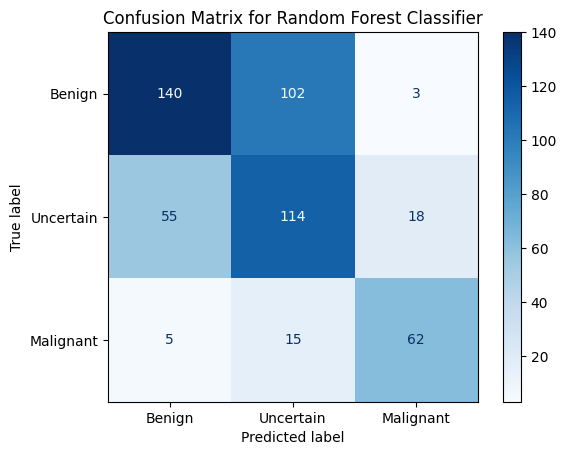

In [63]:
import matplotlib.pyplot as plt
cm = confusion_matrix(testy, predy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign","Uncertain","Malignant"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [50]:
df2=df[0]
df3=df[1]
new_dataset="datasets/pylidc_features_nl.csv"
df4=pd.read_csv(new_dataset)

In [51]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 42)
split = splitter.split(df4, groups=df4['PatientID'])
train_inds, test_inds = next(split)
train = df4.iloc[train_inds]
test = df4.iloc[test_inds]

In [52]:
testy2=test["Label"]
testx2=test.drop(["Label","PatientID"],axis=1)
trainy2=train["Label"]
trainx2=train.drop(["Label","PatientID"],axis=1)

In [27]:
trainy2.head(5)

0    5
1    5
2    1
3    5
4    3
Name: Label, dtype: int64

In [53]:
rft2 = RandomForestClassifier(n_estimators=1000, max_depth=12, min_samples_split=8,random_state=42) 
rft2.fit(trainx2, trainy2)

RandomForestClassifier(max_depth=12, min_samples_split=8, n_estimators=1000,
                       random_state=42)

In [67]:
predy2=rft2.predict(testx2)
print(classification_report(testy2,predy2))
60
59
62
63

              precision    recall  f1-score   support

           1       0.70      0.56      0.63       245
           3       0.49      0.61      0.55       187
           5       0.75      0.76      0.75        82

    accuracy                           0.61       514
   macro avg       0.65      0.64      0.64       514
weighted avg       0.63      0.61      0.62       514



63

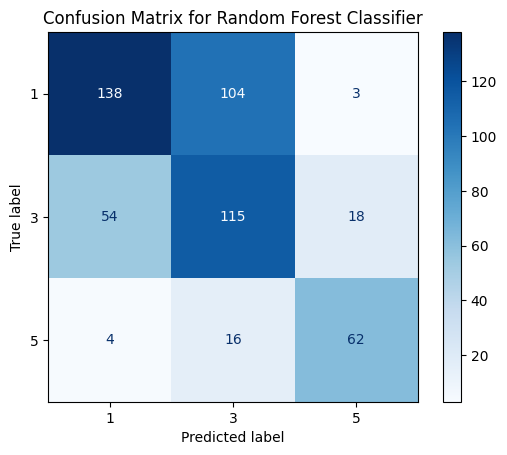

In [30]:
cm = confusion_matrix(testy2, predy2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1","3","5"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()